## **Autoencoders and GANs**

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

### PCA with a linear Autoencoder

In [3]:
# generate 3d data
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
  angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
  data = np.empty((m, 3))
  data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
  data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
  data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
  return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [4]:
## building simple autoencoder for 3d to 2d

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.3532
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 3/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0473
Epoch 4/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 7/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 8/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 11/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 12/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

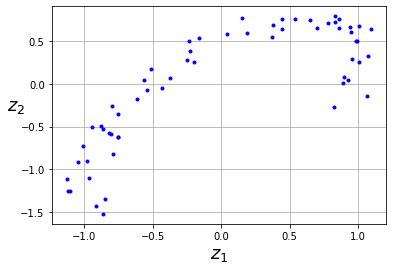

In [7]:
fig = plt.figure()
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

### Stacked Autoencoders

In [8]:
# use MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [9]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
# build autoencoder with 3 hidden layers and 1 output layer
stacked_encoder = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[28, 28]),
      keras.layers.Dense(100, activation="selu"),
      keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
      keras.layers.Dense(100, activation="selu", input_shape=[30]),
      keras.layers.Dense(28*28, activation="sigmoid"),
      keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", 
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3823 - rounded_accuracy: 0.8480 - val_loss: 0.3120 - val_rounded_accuracy: 0.9128
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3070 - rounded_accuracy: 0.9138 - val_loss: 0.3037 - val_rounded_accuracy: 0.9150
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3009 - rounded_accuracy: 0.9198 - val_loss: 0.3007 - val_rounded_accuracy: 0.9190
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2961 - rounded_accuracy: 0.9233 - val_loss: 0.2980 - val_rounded_accuracy: 0.9240
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2933 - rounded_accuracy: 0.9261 - val_loss: 0.2956 - val_rounded_accuracy: 0.9204
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2912 - rounded_accuracy: 0.9278 - val_loss: 0.2905 - val_rounded_accuracy: 0.9299
Epoch 7/20
1719/1719 [==================

In [11]:
# see reconstructed images
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

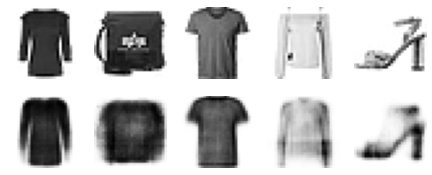

In [12]:
show_reconstructions(stacked_ae)

### Visualizing Fashion MNIST

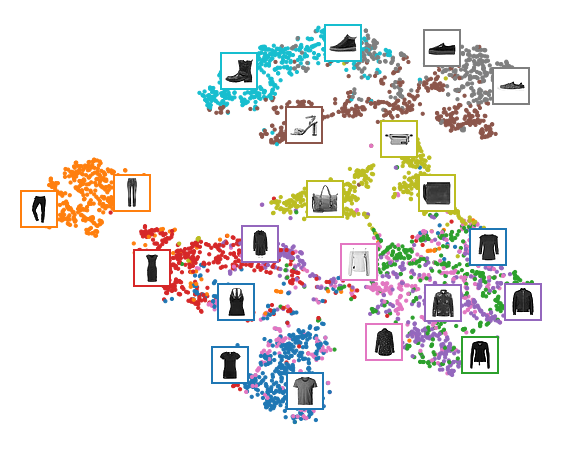

In [13]:
## clustering is done very well with compressed data
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

In [14]:
### tying weights

## simple use the transpose of the encoder's weights as the decoder weights

class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias",
                                  shape=[self.dense.input_shape[-1]],
                                  initializer="zeros")
    super().build(batch_input_shape)
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [15]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3750 - rounded_accuracy: 0.8533 - val_loss: 0.3031 - val_rounded_accuracy: 0.9203
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3007 - rounded_accuracy: 0.9191 - val_loss: 0.2969 - val_rounded_accuracy: 0.9270
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2934 - rounded_accuracy: 0.9258 - val_loss: 0.3013 - val_rounded_accuracy: 0.9085
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2909 - rounded_accuracy: 0.9290 - val_loss: 0.2887 - val_rounded_accuracy: 0.9313
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2872 - rounded_accuracy: 0.9313 - val_loss: 0.2878 - val_rounded_accuracy: 0.9318
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9328 - val_loss: 0.2863 - val_rounded_accuracy: 0.9345
Epoch 7/10
1719/1719 [==================

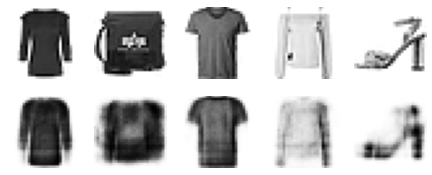

In [16]:
show_reconstructions(tied_ae)

### Training One Autoencoder at a Time

In [17]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
  n_inputs = X_train.shape[-1]
  encoder = keras.models.Sequential([
      keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
  ])
  decoder = keras.models.Sequential([
      keras.layers.Dense(n_inputs, activation=output_activation),
  ])
  autoencoder = keras.models.Sequential([encoder, decoder])
  autoencoder.compile(optimizer, loss, metrics=metrics)
  autoencoder.fit(X_train, X_train, epochs=n_epochs,
                  validation_data=(X_valid, X_valid))
  return encoder, decoder, encoder(X_train), encoder(X_valid)

In [18]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # same as .reshape(-1, 28*28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy]
)
end2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu"
)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3980 - rounded_accuracy: 0.8433 - val_loss: 0.3115 - val_rounded_accuracy: 0.9153
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3062 - rounded_accuracy: 0.9184 - val_loss: 0.3004 - val_rounded_accuracy: 0.9248
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2972 - rounded_accuracy: 0.9268 - val_loss: 0.2935 - val_rounded_accuracy: 0.9315
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2900 - rounded_accuracy: 0.9330 - val_loss: 0.2890 - val_rounded_accuracy: 0.9356
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2859 - rounded_accuracy: 0.9370 - val_loss: 0.2860 - val_rounded_accuracy: 0.9386
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2836 - rounded_accuracy: 0.9397 - val_loss: 0.2837 - val_rounded_accuracy: 0.9405
Epoch 7/10
1719/1719 [==================

In [19]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, end2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

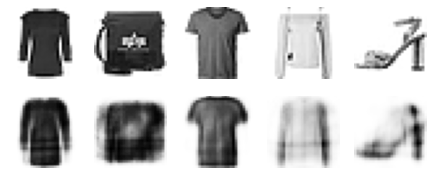

In [20]:
show_reconstructions(stacked_ae_1_by_1)

In [21]:
# train agian with full layers
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2862 - rounded_accuracy: 0.9347 - val_loss: 0.2878 - val_rounded_accuracy: 0.9347
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9354 - val_loss: 0.2876 - val_rounded_accuracy: 0.9350
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9356 - val_loss: 0.2874 - val_rounded_accuracy: 0.9352
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9356 - val_loss: 0.2873 - val_rounded_accuracy: 0.9352
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9355 - val_loss: 0.2872 - val_rounded_accuracy: 0.9358
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2852 - rounded_accuracy: 0.9358 - val_loss: 0.2870 - val_rounded_accuracy: 0.9356
Epoch 7/10
1719/1719 [==================

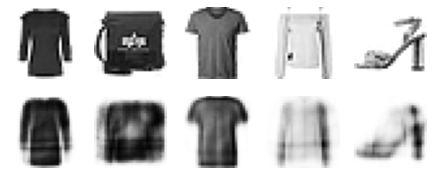

In [22]:
show_reconstructions(stacked_ae_1_by_1)

### Using Convolutional Layers instead of Dense Layers

In [23]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.3359 - rounded_accuracy: 0.8909 - val_loss: 0.2808 - val_rounded_accuracy: 0.9364
Epoch 2/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2778 - rounded_accuracy: 0.9400 - val_loss: 0.2742 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2715 - rounded_accuracy: 0.9456 - val_loss: 0.2701 - val_rounded_accuracy: 0.9492
Epoch 4/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2694 - rounded_accuracy: 0.9484 - val_loss: 0.2687 - val_rounded_accuracy: 0.9501
Epoch 5/5
1719/1719 [==============================] - 62s 36ms/step - loss: 0.2677 - rounded_accuracy: 0.9497 - val_loss: 0.2682 - val_rounded_accuracy: 0.9484


In [24]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

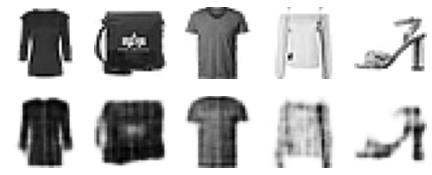

In [26]:
show_reconstructions(conv_ae)
plt.show()

### Recurrent Autoencoders

In [27]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [28]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 89s 49ms/step - loss: 0.5613 - rounded_accuracy: 0.7129 - val_loss: 0.4511 - val_rounded_accuracy: 0.8171
Epoch 2/10
1719/1719 [==============================] - 84s 49ms/step - loss: 0.4278 - rounded_accuracy: 0.8277 - val_loss: 0.3790 - val_rounded_accuracy: 0.8576
Epoch 3/10
1719/1719 [==============================] - 85s 50ms/step - loss: 0.3715 - rounded_accuracy: 0.8661 - val_loss: 0.3653 - val_rounded_accuracy: 0.8686
Epoch 4/10
1719/1719 [==============================] - 85s 50ms/step - loss: 0.3564 - rounded_accuracy: 0.8765 - val_loss: 0.3693 - val_rounded_accuracy: 0.8686
Epoch 5/10
1719/1719 [==============================] - 85s 50ms/step - loss: 0.3452 - rounded_accuracy: 0.8848 - val_loss: 0.3380 - val_rounded_accuracy: 0.8914
Epoch 6/10
1719/1719 [==============================] - 87s 50ms/step - loss: 0.3370 - rounded_accuracy: 0.8897 - val_loss: 0.3394 - val_rounded_accuracy: 0.8871
Epoch 7/10
1719/1719 [======

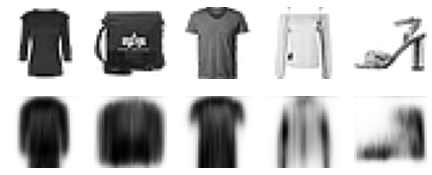

In [29]:
show_reconstructions(recurrent_ae)
plt.show()

### Stacked denoising Autoencoder

In [31]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4019 - rounded_accuracy: 0.8326 - val_loss: 0.3183 - val_rounded_accuracy: 0.9036
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3148 - rounded_accuracy: 0.9072 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3078 - rounded_accuracy: 0.9133 - val_loss: 0.3035 - val_rounded_accuracy: 0.9184
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9167 - val_loss: 0.3005 - val_rounded_accuracy: 0.9219
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3006 - rounded_accuracy: 0.9196 - val_loss: 0.2977 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2983 - rounded_accuracy: 0.9215 - val_loss: 0.2964 - val_rounded_accuracy: 0.9263
Epoch 7/10
1719/1719 [==================

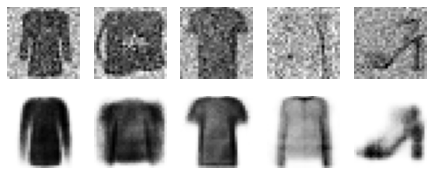

In [32]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [34]:
# using dropout

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4051 - rounded_accuracy: 0.8257 - val_loss: 0.3200 - val_rounded_accuracy: 0.9039
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3201 - rounded_accuracy: 0.9019 - val_loss: 0.3129 - val_rounded_accuracy: 0.9117
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3126 - rounded_accuracy: 0.9077 - val_loss: 0.3062 - val_rounded_accuracy: 0.9146
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3087 - rounded_accuracy: 0.9106 - val_loss: 0.3028 - val_rounded_accuracy: 0.9190
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3058 - rounded_accuracy: 0.9130 - val_loss: 0.3004 - val_rounded_accuracy: 0.9209
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9144 - val_loss: 0.2994 - val_rounded_accuracy: 0.9204
Epoch 7/10
1719/1719 [==================

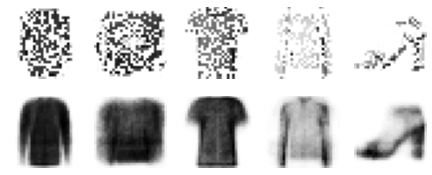

In [38]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

### Sparse Autoencoder

In [39]:
# simple stacked autoencoder, use sigmoid activation function for coding layer

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4882 - rounded_accuracy: 0.7457 - val_loss: 0.3791 - val_rounded_accuracy: 0.8472
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3706 - rounded_accuracy: 0.8555 - val_loss: 0.3568 - val_rounded_accuracy: 0.8714
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3480 - rounded_accuracy: 0.8801 - val_loss: 0.3373 - val_rounded_accuracy: 0.8888
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3315 - rounded_accuracy: 0.8944 - val_loss: 0.3269 - val_rounded_accuracy: 0.9025
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3227 - rounded_accuracy: 0.9010 - val_loss: 0.3211 - val_rounded_accuracy: 0.9055
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3184 - rounded_accuracy: 0.9040 - val_loss: 0.3181 - val_rounded_accuracy: 0.9069
Epoch 7/10
1719/1719 [==================

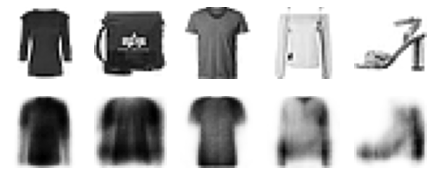

In [40]:
show_reconstructions(simple_ae)
plt.show()

In [41]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

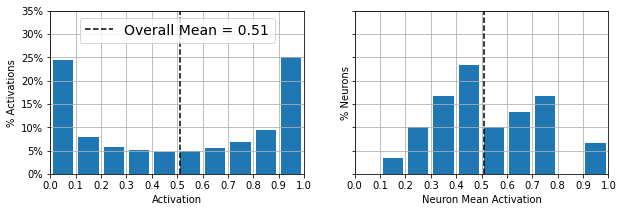

In [42]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [43]:
# add l1 regularization

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4869 - rounded_accuracy: 0.7592 - val_loss: 0.3756 - val_rounded_accuracy: 0.8634
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3644 - rounded_accuracy: 0.8720 - val_loss: 0.3499 - val_rounded_accuracy: 0.8851
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3442 - rounded_accuracy: 0.8902 - val_loss: 0.3374 - val_rounded_accuracy: 0.8946
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3329 - rounded_accuracy: 0.8982 - val_loss: 0.3299 - val_rounded_accuracy: 0.9011
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3273 - rounded_accuracy: 0.9021 - val_loss: 0.3265 - val_rounded_accuracy: 0.9045
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3238 - rounded_accuracy: 0.9043 - val_loss: 0.3231 - val_rounded_accuracy: 0.9070
Epoch 7/10
1719/1719 [==================

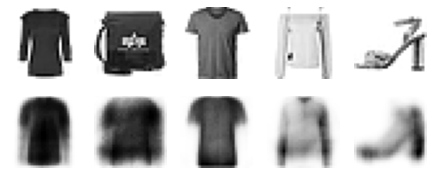

In [44]:
show_reconstructions(sparse_l1_ae)

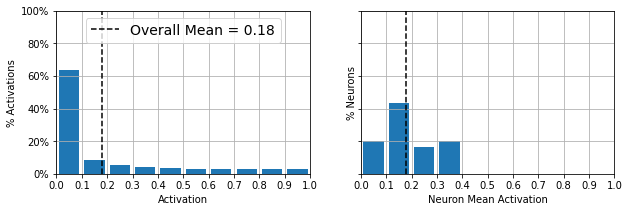

In [45]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

### using KL Divergence

In [46]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities)
    )

In [47]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4740 - rounded_accuracy: 0.7646 - val_loss: 0.3688 - val_rounded_accuracy: 0.8621
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3576 - rounded_accuracy: 0.8725 - val_loss: 0.3424 - val_rounded_accuracy: 0.8873
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3358 - rounded_accuracy: 0.8899 - val_loss: 0.3283 - val_rounded_accuracy: 0.8981
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3235 - rounded_accuracy: 0.9008 - val_loss: 0.3209 - val_rounded_accuracy: 0.9046
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3170 - rounded_accuracy: 0.9057 - val_loss: 0.3172 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3140 - rounded_accuracy: 0.9087 - val_loss: 0.3143 - val_rounded_accuracy: 0.9091
Epoch 7/10
1719/1719 [==================

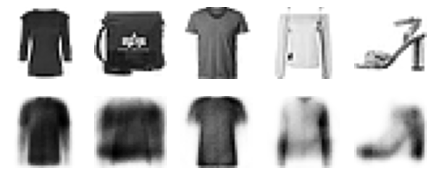

In [48]:
show_reconstructions(sparse_kl_ae)

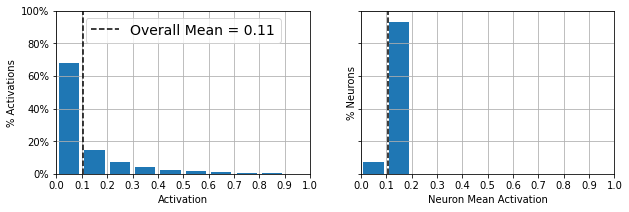

In [49]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

### Variational Autoencoder

In [54]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [56]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28*28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 8s 16ms/step - loss: 0.4436 - rounded_accuracy: 0.8175 - val_loss: 0.3563 - val_rounded_accuracy: 0.8824
Epoch 2/25
430/430 [==============================] - 6s 15ms/step - loss: 0.3465 - rounded_accuracy: 0.8950 - val_loss: 0.3422 - val_rounded_accuracy: 0.9021
Epoch 3/25
430/430 [==============================] - 6s 15ms/step - loss: 0.3339 - rounded_accuracy: 0.9049 - val_loss: 0.3294 - val_rounded_accuracy: 0.9101
Epoch 4/25
430/430 [==============================] - 6s 15ms/step - loss: 0.3282 - rounded_accuracy: 0.9087 - val_loss: 0.3272 - val_rounded_accuracy: 0.9130
Epoch 5/25
430/430 [==============================] - 6s 15ms/step - loss: 0.3251 - rounded_accuracy: 0.9115 - val_loss: 0.3248 - val_rounded_accuracy: 0.9135
Epoch 6/25
430/430 [==============================] - 6s 14ms/step - loss: 0.3220 - rounded_accuracy: 0.9136 - val_loss: 0.3247 - val_rounded_accuracy: 0.9096
Epoch 7/25
430/430 [==========================

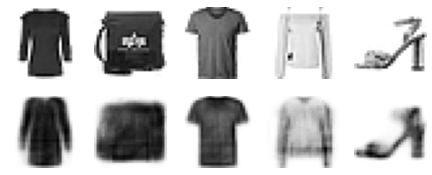

In [57]:
show_reconstructions(variational_ae)
plt.show()

In [58]:
# generate fashion image
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index+1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

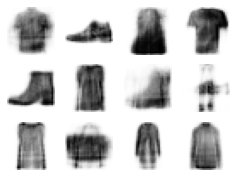

In [59]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)